# Combined Simulations

In [1]:
import pandas as pd
import statsmodels.api as sm
from sklearn.preprocessing import MinMaxScaler
import os
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import griddata

filename = "/Users/jiahuili/PycharmProjects/GenAI_Customer/robustness_check_v1.csv"

df = pd.read_csv(filename)

df.head()

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


,LowSatisfaction,MediumSatisfaction,HighSatisfaction,Sales,Sales (Willing),Sales (Unwilling),Sold Products,Sold Products (Willing),Sold Products (Unwilling),Average Seller Rating,...,AIC Quartic (Unwilling),learning_rate_customer,learning_rate_gen_ai,num_customers,num_products,num_retailers,percentage_willing_to_share_info,purchase_threshold,total_steps,capacity_gen_ai
0,47,0,3,2.655443,2.655443,0,5,5,0,-0.329813,...,NaN,0.3,0.4,50,60,10,1,1.5,40,0
1,2,0,48,270.489031,270.489031,0,272,272,0,43.655991,...,NaN,0.3,0.4,50,60,10,1,1.5,40,1
2,22,3,25,154.883103,154.883103,0,93,93,0,6.668784,...,NaN,0.3,0.4,50,60,10,1,1.5,40,0
3,24,2,24,171.999492,171.999492,0,140,140,0,6.040222,...,NaN,0.3,0.4,50,60,10,1,1.5,40,1
4,36,2,12,62.161163,62.161163,0,45,45,0,0.449897,...,NaN,0.3,0.4,50,60,10,1,1.5,40,0


In [2]:
df.loc[df['capacity_gen_ai'] == 0, 'percentage_willing_to_share_info'] = 0

# df.loc[df['percentage_willing_to_share_info'] == 0, 'creativity_gen_ai'] = 0
# df.loc[df['percentage_willing_to_share_info'] == 0, 'learning_rate_gen_ai'] = 0

# select columns
df_select = df[['total_steps', 'Average Satisfaction', 'learning_rate_gen_ai', 'capacity_gen_ai','creativity_gen_ai', 'percentage_willing_to_share_info', 'num_customers', 'num_retailers', 'num_products','AIC Quartic (Sum)', 'AIC Quartic (Minimum)', 'Average Seller Rating']]

df_select.replace([-np.inf, np.inf], np.nan, inplace=True)

df_select.dropna(inplace=True)

/var/folders/lx/qwfk5l855bq3cnpg8br590200000gn/T/ipykernel_16816/820162980.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_select.replace([-np.inf, np.inf], np.nan, inplace=True)
/var/folders/lx/qwfk5l855bq3cnpg8br590200000gn/T/ipykernel_16816/820162980.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_select.dropna(inplace=True)


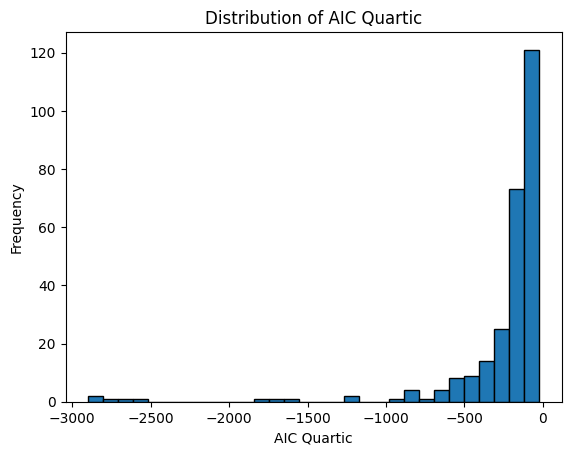

In [3]:
# Plotting the distribution of 'aic_quartic_original'
plt.hist(df_select['AIC Quartic (Minimum)'], bins=30, edgecolor='k')
plt.xlabel('AIC Quartic')
plt.ylabel('Frequency')
plt.title('Distribution of AIC Quartic')
plt.show()


In [4]:
# Remove rows where 'aic_quartic_original' is too small
df_select = df_select[df_select['AIC Quartic (Minimum)'] >= -500]

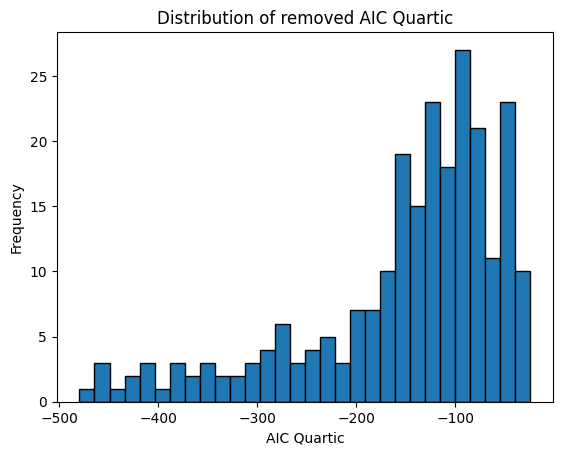

In [5]:
# Plotting the distribution of 'aic_quartic_original'
plt.hist(df_select['AIC Quartic (Minimum)'], bins=30, edgecolor='k')
plt.xlabel('AIC Quartic')
plt.ylabel('Frequency')
plt.title('Distribution of removed AIC Quartic')
plt.show()

# Data Normalization

In [6]:
# select columns
data = df_select[['Average Satisfaction', 'learning_rate_gen_ai', 'capacity_gen_ai','creativity_gen_ai', 'percentage_willing_to_share_info', 'num_customers', 'num_retailers', 'num_products','AIC Quartic (Sum)','AIC Quartic (Minimum)', 'Average Seller Rating']]

original_aic_quartic = data['AIC Quartic (Minimum)'].copy()

# Create an instance of MinMaxScaler
scaler = MinMaxScaler()

data_normalized = scaler.fit_transform(data)

# Apply Min-Max scaling to the specified columns
# This scales the data in these columns to a range between 0 and 1
data_normalized_df = pd.DataFrame(data_normalized, columns=data.columns)

data_normalized_df['AIC Quartic (Minimum) Original'] = original_aic_quartic.reset_index(drop=True)

# Split Number of Products

In [7]:
# Determine the minimum and maximum values of the 'num_products' column
min_num_products = data_normalized_df['num_products'].min()
max_num_products = data_normalized_df['num_products'].max()

# Calculate the range for each segment (low, medium, high) for 'num_products'
range_per_part = (max_num_products - min_num_products) / 3

# Define thresholds for low, medium, and high categories for 'num_products'
low_threshold = min_num_products + range_per_part
medium_threshold = min_num_products + 2 * range_per_part

# Creating new columns for low, medium, and high creativity rates
# Assigning 1 if the condition is true, else 0
data_normalized_df['Products Low'] = (data_normalized_df['num_products'] <= low_threshold).astype(int)
data_normalized_df['Products Medium'] = ((data_normalized_df['num_products'] > low_threshold) & (data_normalized_df['num_products'] <= medium_threshold)).astype(int)
data_normalized_df['Products High'] = (data_normalized_df['num_products'] > medium_threshold).astype(int)

In [8]:
# rename columns
data = data_normalized_df.rename(columns={
    'Average Satisfaction': 'avg_satisfaction',
    'Average Seller Rating': 'avg_rating',
    'learning_rate_gen_ai': 'gen_ai_learning_rate',
    'capacity_gen_ai': 'gen_ai_capacity',
    'creativity_gen_ai': 'gen_ai_creativity',
    'percentage_willing_to_share_info': 'implement_gen_ai',
    'num_customers': 'n_customer',
    'num_retailers': 'n_seller',
    'num_products': 'n_product',
    'AIC Quartic (Minimum)': 'aic_quartic_min',
    'AIC Quartic (Sum)': 'aic_quartic_sum'
})

data.head(10)

,avg_satisfaction,gen_ai_learning_rate,gen_ai_capacity,gen_ai_creativity,implement_gen_ai,n_customer,n_seller,n_product,aic_quartic_sum,aic_quartic_min,avg_rating,AIC Quartic (Minimum) Original,Products Low,Products Medium,Products High
0,0.022201,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.750472,0.934910,0.087260,-53.525059,1,0,0
1,0.207729,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.907506,0.979788,0.140766,-33.067795,1,0,0
2,0.286460,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.853269,0.913320,0.135960,-63.366553,1,0,0
3,0.114855,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.860751,0.982383,0.093221,-31.885036,1,0,0
4,0.195707,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.824199,0.962266,0.126719,-41.054904,1,0,0
5,0.383529,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.875470,0.951630,0.175029,-45.903426,1,0,0
6,0.667750,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.385198,0.298200,0.288143,-343.759545,1,0,0
7,0.173233,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.874526,0.945754,0.129279,-48.581758,1,0,0
8,0.642427,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.693547,0.859886,0.226148,-87.723564,1,0,0
9,0.222522,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.898451,0.958864,0.125741,-42.605845,1,0,0


# Implementation of Gen AI

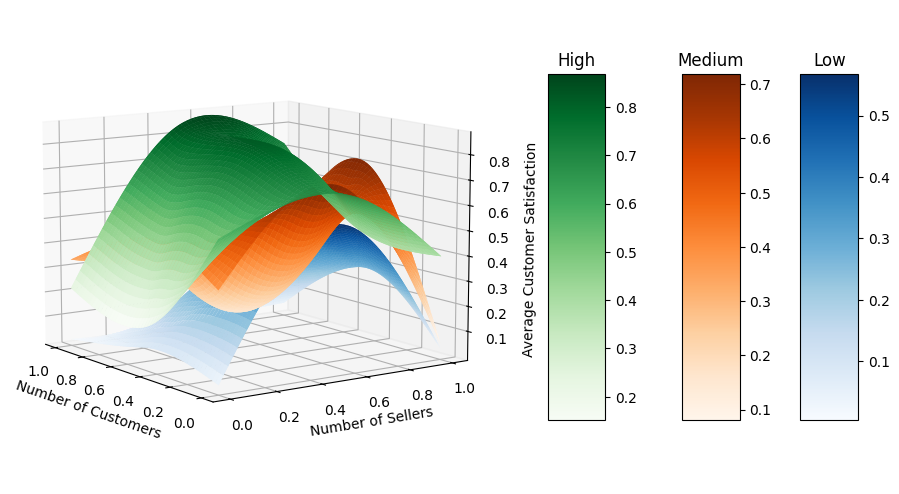

In [9]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import griddata
import matplotlib.lines as mlines

fig = plt.figure(figsize=(12, 9)) 
ax = fig.add_subplot(111, projection='3d')

cmaps = ['Blues', 'Oranges', 'Greens'] # Different color maps for each category

# Loop through each learning rate condition
for i, rate in enumerate(['Products Low', 'Products Medium', 'Products High']):
    # Filtering data based on the learning rate
    subset = data[data[rate] == 1]

    # Extracting data for the axes
    x = subset['n_customer']
    y = subset['n_seller']
    z = subset['avg_satisfaction']

    # Creating a grid to interpolate
    xi = np.linspace(x.min(), x.max(), 100)
    yi = np.linspace(y.min(), y.max(), 100)
    xi, yi = np.meshgrid(xi, yi)
    zi = griddata((x, y), z, (xi, yi), method='cubic')

    # Plotting the surface for each subset
    surf = ax.plot_surface(xi, yi, zi, cmap=cmaps[i], edgecolor='none')

    # Plotting the surface for each subset
    surf = ax.plot_surface(xi, yi, zi, cmap=cmaps[i], edgecolor='none')

    # Adding a color bar for each surface and setting a title for it
    cbar = fig.colorbar(surf, ax=ax, shrink=0.5, aspect=6, pad=0.05*i)
    cbar.ax.set_title(rate.split()[1])  # Set title for each color bar

ax.view_init(elev=10, azim=-35)


# Setting labels for each axis
ax.set_xlabel('Number of Customers')
ax.set_ylabel('Number of Sellers')
ax.set_zlabel('Average Customer Satisfaction')

# Inverting X axes
ax.set_xlim(ax.get_xlim()[::-1])

plt.show()

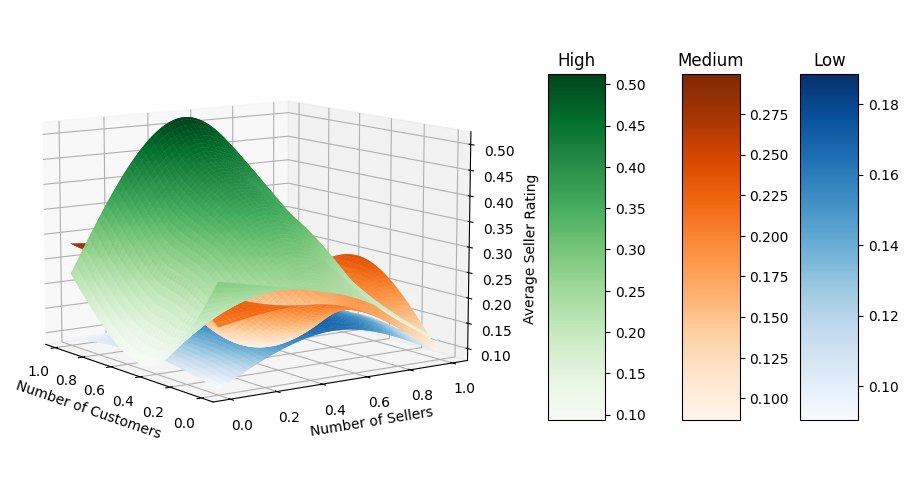

In [10]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import griddata
import matplotlib.lines as mlines

fig = plt.figure(figsize=(12, 9)) 
ax = fig.add_subplot(111, projection='3d')

cmaps = ['Blues', 'Oranges', 'Greens'] # Different color maps for each category

# Loop through each learning rate condition
for i, rate in enumerate(['Products Low', 'Products Medium', 'Products High']):
    # Filtering data based on the learning rate
    subset = data[data[rate] == 1]

    # Extracting data for the axes
    x = subset['n_customer']
    y = subset['n_seller']
    z = subset['avg_rating']

    # Creating a grid to interpolate
    xi = np.linspace(x.min(), x.max(), 100)
    yi = np.linspace(y.min(), y.max(), 100)
    xi, yi = np.meshgrid(xi, yi)
    zi = griddata((x, y), z, (xi, yi), method='cubic')

    # Plotting the surface for each subset
    surf = ax.plot_surface(xi, yi, zi, cmap=cmaps[i], edgecolor='none')

    # Plotting the surface for each subset
    surf = ax.plot_surface(xi, yi, zi, cmap=cmaps[i], edgecolor='none')

    # Adding a color bar for each surface and setting a title for it
    cbar = fig.colorbar(surf, ax=ax, shrink=0.5, aspect=6, pad=0.05*i)
    cbar.ax.set_title(rate.split()[1])  # Set title for each color bar

ax.view_init(elev=10, azim=-35)


# Setting labels for each axis
ax.set_xlabel('Number of Customers')
ax.set_ylabel('Number of Sellers')
ax.set_zlabel('Average Seller Rating')

# Inverting X axes
ax.set_xlim(ax.get_xlim()[::-1])

plt.show()

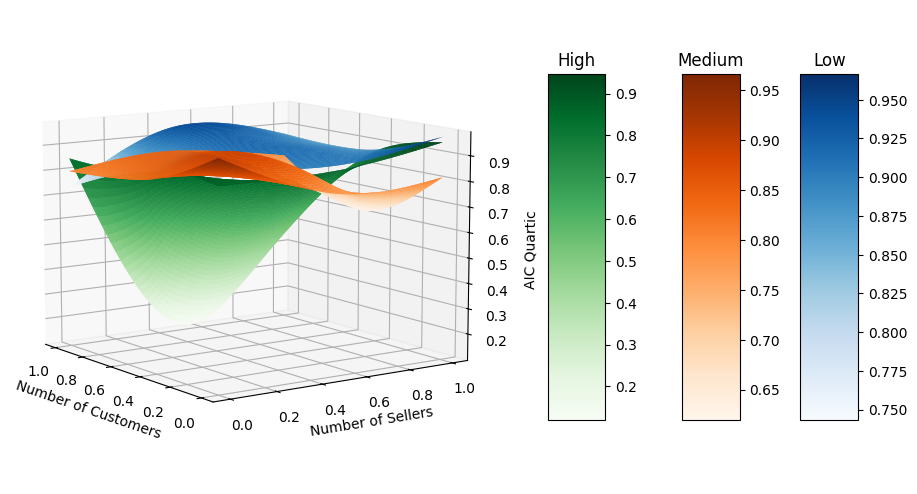

In [11]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import griddata
import matplotlib.lines as mlines

fig = plt.figure(figsize=(12, 9)) 
ax = fig.add_subplot(111, projection='3d')

cmaps = ['Blues', 'Oranges', 'Greens'] # Different color maps for each category

# Loop through each learning rate condition
for i, rate in enumerate(['Products Low', 'Products Medium', 'Products High']):
    # Filtering data based on the learning rate
    subset = data[data[rate] == 1]

    # Extracting data for the axes
    x = subset['n_customer']
    y = subset['n_seller']
    z = subset['aic_quartic_min']

    # Creating a grid to interpolate
    xi = np.linspace(x.min(), x.max(), 100)
    yi = np.linspace(y.min(), y.max(), 100)
    xi, yi = np.meshgrid(xi, yi)
    zi = griddata((x, y), z, (xi, yi), method='cubic')

    # Plotting the surface for each subset
    surf = ax.plot_surface(xi, yi, zi, cmap=cmaps[i], edgecolor='none')

    # Plotting the surface for each subset
    surf = ax.plot_surface(xi, yi, zi, cmap=cmaps[i], edgecolor='none')

    # Adding a color bar for each surface and setting a title for it
    cbar = fig.colorbar(surf, ax=ax, shrink=0.5, aspect=6, pad=0.05*i)
    cbar.ax.set_title(rate.split()[1])  # Set title for each color bar

ax.view_init(elev=10, azim=-35)


# Setting labels for each axis
ax.set_xlabel('Number of Customers')
ax.set_ylabel('Number of Sellers')
ax.set_zlabel('AIC Quartic')

# Inverting X axes
ax.set_xlim(ax.get_xlim()[::-1])

plt.show()